# Fundamentos de Inteligência Artificial - Trabalho Prático 2

## Problema - Coloração de Grafos: 

O problema de coloração em grafos em sua forma mais tradicional consiste na rotulação (atribuição de uma cor) de vértices de um grafo, os quais estão sujeitos a restrições previamente definidas. A restrição usualmente imposta é que dois vértices vizinhos, isto é, que compartilham uma mesma aresta, não podem possuir a mesma cor.

Neste notebook, uma instância desse problema é modelada como um grafo de restrições (Constraint Graph), onde as arestas representam as restrições binárias entre os vértices (variáveis do problema). Para construir este grafo, utilizaremos a mesma estrutura de dados (class Graph) que foi fornecida no Estudo Dirigido 1 sobre Busca em Grafos.

In [22]:
import time
import pandas as pd
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
class Edge:
    def __init__(self, u, v, w):
        self.u = u  # starting vertex
        self.v = v  # ending vertex
        self.w = w  # weight of the edge

    def __lt__(self, other):
        # This makes the edges comparable by weight for sorting
        return self.w < other.w

    def __str__(self):
        # String representation of an edge
        return f"{self.u} -> {self.v} ({self.w})"

    def __repr__(self):
        return self.__str__()

class Graph:
    def __init__(self):
        # Initialize a graph with no predefined number of vertices
        self.graph = {}  # key: vertex, value: list of edges

    def add_edge(self, u, v, w):
        # Add an edge from u to v with weight w
        if u not in self.graph:
            self.graph[u] = []
        if v not in self.graph:
            self.graph[v] = []

        self.graph[u].append(Edge(u, v, w))

    def add_undirected_edge(self, u, v, w):
        # Add an undirected edge between u and v with weight w
        self.add_edge(u, v, w)
        self.add_edge(v, u, w)

    def __str__(self):
        # String representation of the entire graph
        result = []
        for u in self.graph:
            for edge in self.graph[u]:
                result.append(str(edge))
        return "\n".join(result)

    def get_edges(self):
        # Returns all edges in the graph
        edges = []
        for u in self.graph:
            for edge in self.graph[u]:
                edges.append(edge)
        return edges

    def out_degree(self, u):
        # Return the out-degree of vertex u
        if u in self.graph:
            return len(self.graph[u])
        else:
            raise ValueError(f"Vertex {u} not found in the graph.")

    def in_degree(self, v):
        # Return the in-degree of vertex v
        in_deg = 0
        for u in self.graph:
            for edge in self.graph[u]:
                if edge.v == v:
                    in_deg += 1
        return in_deg

    def get_neighbors(self, u):
        # Returns the neighbors of vertex u
        if u in self.graph:
            return [edge.v for edge in self.graph[u]]
        else:
            raise ValueError(f"Vertex {u} not found in the graph.")

### Instância do Problema de Coloração em Grafos: 

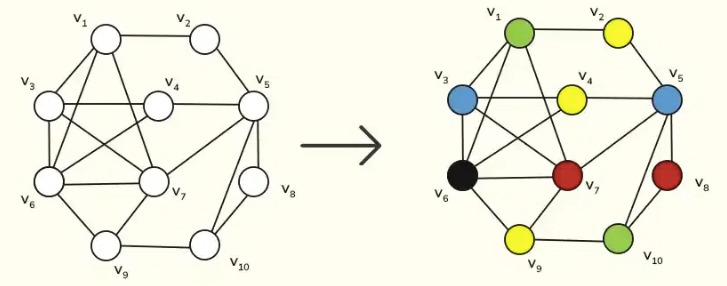

In [24]:
Example = Graph()

Example.add_undirected_edge("V1", "V2", 1)
Example.add_undirected_edge("V1", "V3", 1)
Example.add_undirected_edge("V1", "V6", 1)
Example.add_undirected_edge("V1", "V7", 1)
Example.add_undirected_edge("V2", "V5", 1)
Example.add_undirected_edge("V3", "V4", 1)
Example.add_undirected_edge("V3", "V6", 1)
Example.add_undirected_edge("V3", "V7", 1)
Example.add_undirected_edge("V4", "V5", 1)
Example.add_undirected_edge("V4", "V6", 1)
Example.add_undirected_edge("V5", "V7", 1)
Example.add_undirected_edge("V5", "V8", 1)
Example.add_undirected_edge("V5", "V10", 1)
Example.add_undirected_edge("V6", "V7", 1)
Example.add_undirected_edge("V6", "V9", 1)
Example.add_undirected_edge("V8", "V10", 1)
Example.add_undirected_edge("V9", "V10", 1)

In [25]:
print(Example)

V1 -> V2 (1)
V1 -> V3 (1)
V1 -> V6 (1)
V1 -> V7 (1)
V2 -> V1 (1)
V2 -> V5 (1)
V3 -> V1 (1)
V3 -> V4 (1)
V3 -> V6 (1)
V3 -> V7 (1)
V6 -> V1 (1)
V6 -> V3 (1)
V6 -> V4 (1)
V6 -> V7 (1)
V6 -> V9 (1)
V7 -> V1 (1)
V7 -> V3 (1)
V7 -> V5 (1)
V7 -> V6 (1)
V5 -> V2 (1)
V5 -> V4 (1)
V5 -> V7 (1)
V5 -> V8 (1)
V5 -> V10 (1)
V4 -> V3 (1)
V4 -> V5 (1)
V4 -> V6 (1)
V8 -> V5 (1)
V8 -> V10 (1)
V10 -> V5 (1)
V10 -> V8 (1)
V10 -> V9 (1)
V9 -> V6 (1)
V9 -> V10 (1)


***
### Implementação da Função contar_conflitos(grafo, coloracao). 

#### Entrada:

- o grafo (objeto da classe Graph)

- um dicionário coloracao, onde coloracao[vértice] = cor atribuída

#### Saída:

- número total de conflitos (arestas entre vértices de mesma cor)

In [26]:
def contar_conflitos(grafo, coloracao):
    conflitos = 0
    visitados = set()

    for u in grafo.graph:
        for vizinho in grafo.get_neighbors(u):
            if (u, vizinho) not in visitados and (vizinho, u) not in visitados:
                if coloracao[u] == coloracao[vizinho]:
                    conflitos += 1
                visitados.add((u, vizinho))
                visitados.add((vizinho, u))

    return conflitos

#### Explicação rápida:

- Percorremos todas as arestas do grafo.

- Para cada par (u, vizinho), verificamos se já contamos esse par (usando o conjunto visitados).

- Se os dois vértices tiverem a mesma cor, incrementamos o contador de conflitos.

Essa função será útil para guiar as heurísticas de busca que implementaremos a seguir. Vamos agora testar se ela funciona, passando como argumento uma coloração, ou seja, uma atribuição de cores a cada vértice na forma de um dicionário:

In [27]:
coloracao_exemplo = {
    "V1": "vermelho",
    "V2": "azul",
    "V3": "vermelho",
    "V4": "amarelo",
    "V5": "azul",
    "V6": "verde",  
    "V7": "vermelho",
    "V8": "azul",
    "V9": "verde",
    "V10": "vermelho"
}

print("Conflitos:", contar_conflitos(Example, coloracao_exemplo))

Conflitos: 6


***
### Implementação da Função que gera uma atribuição (coloração) aleatória. 
- serve para gerar uma atribuição inicial para o problema de coloração de grafos.
- Entrada: Grafo de restrições e lista de possíveis cores para seus vértices.
- Saída: dicionário -> key: vertice, value: cor


In [28]:
import random

def gerar_coloracao_aleatoria(grafo, cores=["vermelho", "azul", "verde", "amarelo"]):
    coloracao = {}
    for vertice in grafo.graph.keys():
        coloracao[vertice] = random.choice(cores)
    return coloracao

In [29]:
# Gerar uma coloração aleatória
coloracao_aleatoria = gerar_coloracao_aleatoria(Example)

# Mostrar a coloração gerada
print("Coloração Aleatória:")
for vertice, cor in coloracao_aleatoria.items():
    print(f"{vertice}: {cor}")

# Contar conflitos
num_conflitos = contar_conflitos(Example, coloracao_aleatoria)
print("\nNúmero de conflitos:", num_conflitos)

Coloração Aleatória:
V1: verde
V2: azul
V3: vermelho
V6: azul
V7: azul
V5: vermelho
V4: amarelo
V8: azul
V10: vermelho
V9: vermelho

Número de conflitos: 3


# Heurísticas

Nesta etapa, você deverá implementar algumas heurísticas de busca para resolver o problema de coloração.

***

### Implementação das Heurísticas:

#### Random Walk (RW)
- Escolhe aleatoriamente uma variável e muda sua cor aleatoriamente.
- Se melhorar (reduzir conflitos), aceita.
- Senão, também pode aceitar (não é obrigatório ser só melhoria, você pode definir uma probabilidade mais baixa para aceitar pioras).

#### Best Improvement (BI)
- Testa TODAS as mudanças possíveis (todos vértices e cores).
- Escolhe a mudança que mais reduz conflitos.

#### First Improvement com Any Conflict (FI with AC):
- Escolhe aleatoriamente uma variável que está em conflito.
- Tenta todas as cores possíveis para ela.
- Escolhe a cor que mais reduz conflitos (best color para aquela variável).

#### Simulated Annealing (SA)
- Parecido com FI, mas aceita piores soluções com uma probabilidade que diminui com o tempo (controle de temperatura).

#### Algoritmo Genético (GA):
- Evolui um conjunto de soluções candidatas, denominado população;
- A cada passo, as soluções atuais interagem entre si, através dos operadores de recombinação (crossover) e mutação (mutation) para produzir uma nova população. 

#### Random Walk (RW)

In [30]:
def random_walk(grafo, coloracao_inicial, cores, max_iter=1000):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)

    for _ in range(max_iter):
        vizinho = coloracao.copy()
        vertice_aleatorio = random.choice(list(grafo.graph.keys()))
        nova_cor = random.choice(cores)
        vizinho[vertice_aleatorio] = nova_cor
        conflitos = contar_conflitos(grafo, vizinho)

        if conflitos == 0:
            break

    return coloracao, conflitos
    return coloracao, conflitos


#### Best Improvement (BI)

In [31]:
def best_vizinho(grafo, coloracao_inicial, cores, vertice):
    custos=[]

    n_vertices= len(grafo.graph.keys())
    n_colors= len(cores)
    for vertice in grafo.graph.keys():
        for cor in cores:
            nova_coloracao = coloracao_inicial.copy()
            nova_coloracao[vertice] = cor
            conflitos_novos = contar_conflitos(grafo, nova_coloracao)
            custos.append(conflitos_novos)

    #seleciona apenas cores que tenham menor custo
    min_custo = min(custos)
    indices_menor_custo = [i for i, custo in enumerate(custos) if custo == min_custo]
    #escolhe aleatoriamente entre as cores de menor custo -> satistafaz premissa BI e adiciona stocasticidade
    indice_escolhido = random.choice(indices_menor_custo)
    vertice_escolhido = list(grafo.graph.keys())[indice_escolhido // n_colors]
    cor_escolhida = cores[indice_escolhido % n_colors]
    nova_coloracao = coloracao_inicial.copy()
    nova_coloracao[vertice_escolhido] = cor_escolhida
    return nova_coloracao

def best_improvement(grafo, coloracao_inicial, cores, max_iter=1000):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)

    for _ in range(max_iter):
        vizinho= best_vizinho(grafo, coloracao, cores, vertice)
        novos_conflitos = contar_conflitos(grafo, vizinho)
        if novos_conflitos < conflitos:
            coloracao = vizinho
            conflitos = novos_conflitos
        if conflitos == 0:
            break

    return coloracao, conflitos

#### First Improvement with Random Search (FI with RS)

In [32]:

def first_improvement_rs(grafo, coloracao_inicial, cores, max_iter=1000):
    coloracao = coloracao_inicial.  copy()
    conflitos = contar_conflitos(grafo, coloracao)

    for _ in range(max_iter):
        vertice= random.choice(list(grafo.graph.keys()))
        random_color = random.choice(cores)
        nova_coloracao = coloracao.copy()
        nova_coloracao[vertice] = random_color
        novos_conflitos = contar_conflitos(grafo, nova_coloracao)
        if novos_conflitos < conflitos:
            coloracao = nova_coloracao
            conflitos = novos_conflitos
        if conflitos == 0:
            break   

    return coloracao, conflitos

#### First Improvement with Any Conflict (FI with AC)

In [33]:
def get_vertices_em_conflito(grafo, coloracao):
    conflitos = 0
    visitados = set()
    conflitantes = set()
    for u in grafo.graph:
        for vizinho in grafo.get_neighbors(u):
            if (u, vizinho) not in visitados and (vizinho, u) not in visitados:
                if coloracao[u] == coloracao[vizinho]:
                    conflitantes.add(u)
                    conflitantes.add(vizinho)
                    conflitos += 1
                visitados.add((u, vizinho))
                visitados.add((vizinho, u))

    return conflitantes

def first_improvement_ac(grafo, coloracao_inicial, cores, max_iter=1000):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)

    for _ in range(max_iter):
        vertices_conflitantes = get_vertices_em_conflito(grafo, coloracao)
        vertice = random.choice(list(vertices_conflitantes))
        custo= contar_conflitos(grafo, coloracao)
        for cor in cores:
            nova_coloracao = coloracao.copy()
            nova_coloracao[vertice] = cor
            novos_conflitos = contar_conflitos(grafo, nova_coloracao)
            if novos_conflitos < custo:
                coloracao = nova_coloracao
                conflitos = novos_conflitos
                break
        if conflitos == 0:
            break

    return coloracao, conflitos

#### Simulated Annealing (SA)

In [34]:
import math

def simulated_annealing(grafo, coloracao_inicial, cores, max_iter=1000, temperatura_inicial=1000, taxa_resfriamento=0.995):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)
    temperatura = temperatura_inicial

    for _ in range(max_iter):
        solucao_vizinha = coloracao.copy()
        vertices = list(grafo.graph.keys())
        vertice = random.choice(vertices)

        cor_atual = solucao_vizinha[vertice]
        cores_possiveis = []
        for cor in cores:
            if cor != cor_atual:
                cores_possiveis.append(cor)
        nova_cor = random.choice(cores_possiveis)

        solucao_vizinha[vertice] = nova_cor
        novos_conflitos = contar_conflitos(grafo, solucao_vizinha)
        delta = novos_conflitos - conflitos

        if delta < 0:
            coloracao = solucao_vizinha
            conflitos = novos_conflitos
        else:
            prob_aceitar = math.exp(-delta / temperatura)
            if random.random() < prob_aceitar:
                coloracao = solucao_vizinha
                conflitos = novos_conflitos

        temperatura *= taxa_resfriamento

        if conflitos == 0 or temperatura < 1e-6:
            break

    return coloracao, conflitos


#### Genetic Algorithm (GA)

In [35]:
def criar_populacao_inicial(grafo, num_individuos, cores_disponiveis):
    populacao = []
    for _ in range(num_individuos):
        individuo = {}
        for vertice in grafo.graph.keys():
            individuo[vertice] = random.choice(cores_disponiveis)
        populacao.append(individuo)
    return populacao


def calcula_fitness(individuo, grafo):
    conflitos = contar_conflitos(grafo, individuo)
    fitness = conflitos
    return fitness


def selecao_com_annealing(populacao, grafo, temperatura):
    custos = [calcula_fitness(individuo, grafo) for individuo in populacao]
    pesos = [math.exp(-custo / temperatura) for custo in custos]
    soma_pesos = sum(pesos)
    if soma_pesos == 0:
        pesos_normalizados = [1 / len(populacao)] * len(populacao)
    else:
        pesos_normalizados = [p / soma_pesos for p in pesos]
    indice = random.choices(range(len(populacao)), weights=pesos_normalizados, k=1)[0]
    return indice


def crossover(pai1, pai2):
    vertices = list(pai1.keys())
    ponto_corte = random.randint(1, len(vertices) - 1)
    filho1 = {}
    filho2 = {}

    for i in range(len(vertices)):
        vertice = vertices[i]
        if i < ponto_corte:
            filho1[vertice] = pai1[vertice]
            filho2[vertice] = pai2[vertice]
        else:
            filho1[vertice] = pai2[vertice]
            filho2[vertice] = pai1[vertice]

    return filho1, filho2


def mutation(individuo, cores, taxa_mutacao):
    novo_individuo = individuo.copy()
    for vertice in individuo.keys():
        if random.random() < taxa_mutacao:
            cor_atual = individuo[vertice]
            cores_possiveis = []
            for cor in cores:
                if cor != cor_atual:
                    cores_possiveis.append(cor)
            nova_cor = random.choice(cores_possiveis)
            novo_individuo[vertice] = nova_cor
    return novo_individuo

In [36]:
import random
import math

def algoritmo_genetico(grafo, num_individuos, num_geracoes, cores, taxa_mutacao, temperatura_inicial, taxa_resfriamento):
    populacao = criar_populacao_inicial(grafo, num_individuos, cores)
    temperatura = temperatura_inicial

    for geracao in range(num_geracoes):
        populacao_fitness = [calcula_fitness(individuo, grafo) for individuo in populacao]
        melhor_indice = populacao_fitness.index(min(populacao_fitness))
        melhor_individuo = populacao[melhor_indice]
        melhor_fitness = populacao_fitness[melhor_indice]

        print(f"Geração {geracao+1}: Melhor fitness = {melhor_fitness}")

        if melhor_fitness == 0:
            print("\n✅ Solução ótima encontrada!")
            return melhor_individuo, melhor_fitness  # <-- aqui o retorno duplo

        nova_populacao = []

        for _ in range(num_individuos // 2):
            i1 = selecao_com_annealing(populacao, grafo, temperatura)
            i2 = selecao_com_annealing(populacao, grafo, temperatura)
            pai1 = populacao[i1]
            pai2 = populacao[i2]

            filho1, filho2 = crossover(pai1, pai2)
            filho1 = mutation(filho1, cores, taxa_mutacao)
            filho2 = mutation(filho2, cores, taxa_mutacao)

            nova_populacao.append(filho1)
            nova_populacao.append(filho2)

        populacao = nova_populacao
        temperatura *= taxa_resfriamento

    return melhor_individuo, melhor_fitness

***
### Testando as heurísticas de Busca Local:

- Gera uma coloração inicial aleatória.

- Chama cada uma das heurísticas de busca local.

- Mostra o número de conflitos obtido para cada heurística.


In [37]:
cores = ["vermelho", "azul", "verde", "amarelo"]
    
# Gerar uma coloração inicial aleatória
coloracao_inicial = gerar_coloracao_aleatoria(Example, cores)

print("Coloração inicial:")
for vertice, cor in coloracao_inicial.items():
    print(f"{vertice}: {cor}")

conflitos_iniciais = contar_conflitos(Example, coloracao_inicial)
print("\nConflitos iniciais:", conflitos_iniciais)


print("\n--- Aplicando heurísticas ---\n")

# define o número máximo de passos de execução para cada heurística de busca local
max_steps = 1000

# Random Walk
coloracao_rw, conflitos_rw = random_walk(Example, coloracao_inicial, cores, max_steps)
print("Random Walk (RW):")
print(f"Conflitos finais: {conflitos_rw}")
print(coloracao_rw)

# Best Improvement
coloracao_bi, conflitos_bi = best_improvement(Example, coloracao_inicial, cores, max_steps)
print("\nBest Improvement (BI):")
print(f"Conflitos finais: {conflitos_bi}")
print(coloracao_bi)


# First Improvement - Any Conflict
coloracao_fi_ac, conflitos_fi_ac = first_improvement_rs(Example, coloracao_inicial, cores, max_steps)
print("\nFirst Improvement - Any Conflict (FI-AC):")
print(f"Conflitos finais: {conflitos_fi_ac}")
print(coloracao_fi_ac)

# First Improvement - Any Conflict
coloracao_fi_ac, conflitos_fi_ac = first_improvement_ac(Example, coloracao_inicial, cores, max_steps)
print("\nFirst Improvement - Any Conflict (FI-AC):")
print(f"Conflitos finais: {conflitos_fi_ac}")
print(coloracao_fi_ac)

# Simulated Annealing

# define parametros do simulated annealing:
t_0 = 10 # temperatura inicial
alpha = 0.9 # taxa de resfriamento

coloracao_sa, conflitos_sa = simulated_annealing(Example, coloracao_inicial, cores, max_steps, temperatura_inicial=t_0, taxa_resfriamento=alpha)
print("\nSimulated Annealing (SA):")
print(f"Conflitos finais: {conflitos_sa}")
print(coloracao_sa)

Coloração inicial:
V1: amarelo
V2: verde
V3: amarelo
V6: verde
V7: vermelho
V5: amarelo
V4: verde
V8: verde
V10: verde
V9: verde

Conflitos iniciais: 5

--- Aplicando heurísticas ---

Random Walk (RW):
Conflitos finais: 3
{'V1': 'amarelo', 'V2': 'verde', 'V3': 'amarelo', 'V6': 'verde', 'V7': 'vermelho', 'V5': 'amarelo', 'V4': 'verde', 'V8': 'verde', 'V10': 'verde', 'V9': 'verde'}

Best Improvement (BI):
Conflitos finais: 0
{'V1': 'azul', 'V2': 'verde', 'V3': 'amarelo', 'V6': 'verde', 'V7': 'vermelho', 'V5': 'amarelo', 'V4': 'vermelho', 'V8': 'azul', 'V10': 'verde', 'V9': 'vermelho'}

First Improvement - Any Conflict (FI-AC):
Conflitos finais: 0
{'V1': 'amarelo', 'V2': 'verde', 'V3': 'azul', 'V6': 'vermelho', 'V7': 'verde', 'V5': 'amarelo', 'V4': 'verde', 'V8': 'verde', 'V10': 'azul', 'V9': 'verde'}

First Improvement - Any Conflict (FI-AC):
Conflitos finais: 0
{'V1': 'amarelo', 'V2': 'verde', 'V3': 'verde', 'V6': 'azul', 'V7': 'vermelho', 'V5': 'amarelo', 'V4': 'vermelho', 'V8': 'verme

***
### Testando o algoritmo genético:


In [38]:
# Parâmetros
NUM_INDIVIDUOS = 100
NUM_GERACOES = 500
CORES = ["vermelho", "azul", "verde", "amarelo"]
TAXA_MUTACAO = 0.05
TEMPERATURA_INICIAL = 10
TAXA_RESFRIAMENTO = 0.9

# Execução
print("--- Executando o Algoritmo Genético ---")
coloracao_ga, conflitos_ga = algoritmo_genetico(Example, NUM_INDIVIDUOS, NUM_GERACOES, CORES, TAXA_MUTACAO, TEMPERATURA_INICIAL, TAXA_RESFRIAMENTO)

# Impressão do resultado
print("\n Algoritmo Genético (GA):")
print(f"Conflitos finais: {conflitos_ga}")
print(coloracao_ga)

--- Executando o Algoritmo Genético ---
Geração 1: Melhor fitness = 1
Geração 2: Melhor fitness = 1
Geração 3: Melhor fitness = 1
Geração 4: Melhor fitness = 0

✅ Solução ótima encontrada!

 Algoritmo Genético (GA):
Conflitos finais: 0
{'V1': 'vermelho', 'V2': 'amarelo', 'V3': 'azul', 'V6': 'verde', 'V7': 'amarelo', 'V5': 'verde', 'V4': 'amarelo', 'V8': 'vermelho', 'V10': 'amarelo', 'V9': 'azul'}


### Escolha de duas outras instancias: myciel6 e queen13_13

In [39]:
def carregar_grafo_dimacs(caminho_arquivo):
    grafo = Graph()

    with open(caminho_arquivo, "r") as arquivo:
        for linha in arquivo:
            linha = linha.strip()

            if not linha or linha.startswith("c") or linha.startswith("p"):
                continue

            # Cada linha de aresta começa com 'e' e tem dois vértices
            if linha.startswith("e "):
                partes = linha.split()
                if len(partes) == 3:
                    _, u, v = partes
                    grafo.add_undirected_edge(u, v, 1)

    return grafo

# Ler o grafo Myciel6
grafo_myciel = carregar_grafo_dimacs("myciel6.txt")

# Ler o grafo Queen13_13
grafo_queen = carregar_grafo_dimacs("queen13_13.txt")

print("Grafo Myciel6:", len(grafo_myciel.graph), "vértices")
print("Grafo Queen13_13:", len(grafo_queen.graph), "vértices")

Grafo Myciel6: 95 vértices
Grafo Queen13_13: 169 vértices


In [102]:
cores_myciel = [f"cor{i}" for i in range(7)]  # número cromático conhecido
results= []
for i in range(20):
    
    coloracao_inicial = gerar_coloracao_aleatoria(grafo_myciel, cores_myciel)
    coloracao_sa, conflitos_sa = simulated_annealing(grafo_myciel, coloracao_inicial, cores_myciel,  temperatura_inicial=0.1, taxa_resfriamento=0.995)
    results.append(conflitos_sa)
print(results)

[3, 2, 4, 3, 11, 6, 3, 1, 6, 4, 2, 1, 4, 5, 1, 1, 2, 6, 4, 3]


In [ ]:
cores = ["vermelho", "azul", "verde", "amarelo"]
cores_myciel = [f"cor{i}" for i in range(7)]  # número cromático conhecido
coloracao_inicial = gerar_coloracao_aleatoria(grafo_myciel, cores)
coloracao_sa, conflitos_sa = simulated_annealing(grafo_myciel, coloracao_inicial, cores)
print("Myciel6 - Conflitos finais:", conflitos_sa)

coloracao_inicial = gerar_coloracao_aleatoria(grafo_queen, cores)
coloracao_bi, conflitos_bi = simulated_annealing(grafo_queen, coloracao_inicial, cores)
print("Queen13_13 - Conflitos finais:", conflitos_bi)


Myciel6 - Conflitos finais: 177
Queen13_13 - Conflitos finais: 794


### Heuristica DSATUR

In [41]:
def dsatur(grafo, cores):
    coloracao = {}
    vertices = set()

    for u in grafo.graph:
        vertices.add(u)
        for v in grafo.get_neighbors(u):
            vertices.add(v)

    graus = {v: grafo.out_degree(v) if v in grafo.graph else 0 for v in vertices}
    saturacao = {v: 0 for v in vertices}
    nao_coloridos = set(vertices)

    vertice_atual = max(graus, key=graus.get)
    coloracao[vertice_atual] = cores[0]
    nao_coloridos.remove(vertice_atual)

    while nao_coloridos:
        for v in nao_coloridos:
            vizinhos = grafo.get_neighbors(v) if v in grafo.graph else []
            cores_vizinhos = set(coloracao[u] for u in vizinhos if u in coloracao)
            saturacao[v] = len(cores_vizinhos)

        vertice_atual = max(nao_coloridos, key=lambda v: (saturacao[v], graus[v]))
        vizinhos = grafo.get_neighbors(vertice_atual) if vertice_atual in grafo.graph else []
        cores_vizinhos = set(coloracao[u] for u in vizinhos if u in coloracao)

        for cor in cores:
            if cor not in cores_vizinhos:
                coloracao[vertice_atual] = cor
                break

        nao_coloridos.remove(vertice_atual)

    # TO DO: coloquei isso de log pois estava dando erro em 1 dos grafos que importamos (queen13)
    faltando = [v for v in grafo.graph.keys() if v not in coloracao]
    if len(faltando) > 0:
        print(f"{len(faltando)} vértices sem cor detectados:", faltando[:10], "...")
        for v in faltando:
            coloracao[v] = random.choice(cores)
    else:
        print("Todos os vértices foram coloridos corretamente.")

    conflitos = contar_conflitos(grafo, coloracao)
    return coloracao, conflitos


In [42]:
# Exemplo para Myciel6
cores_myciel = [f"cor{i}" for i in range(7)]  # número cromático conhecido
coloracao_dsatur, conflitos_dsatur = dsatur(grafo_myciel, cores_myciel)
print("DSATUR - Myciel6: Conflitos =", conflitos_dsatur)

# Exemplo para Queen13_13
# TO DO: esse era pra estar dando 0 conflitos tambem
cores_queen = [f"cor{i}" for i in range(13)]
coloracao_dsatur, conflitos_dsatur = dsatur(grafo_queen, cores_queen)
print("Queen13_13 - DSATUR: Conflitos =", conflitos_dsatur)

print("Total de vértices:", len(grafo_queen.graph))



Todos os vértices foram coloridos corretamente.
DSATUR - Myciel6: Conflitos = 0
32 vértices sem cor detectados: ['1', '155', '2', '3', '4', '11', '12', '14', '27', '79'] ...
Queen13_13 - DSATUR: Conflitos = 66
Total de vértices: 169


### Search Paramters

  0%|          | 0/20 [00:00<?, ?it/s]

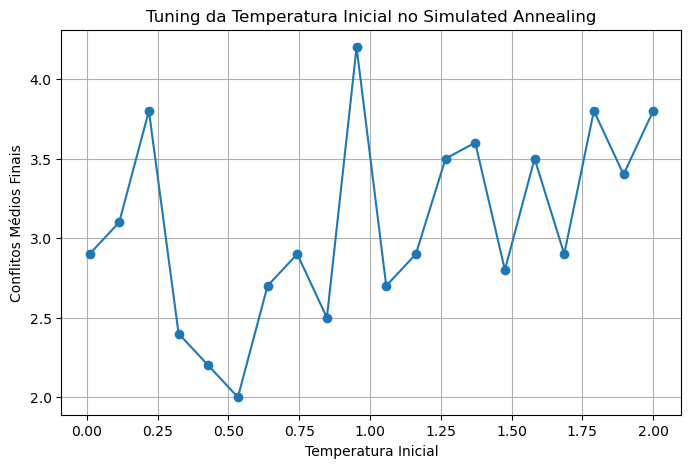

Melhor temperatura inicial: 0.534 (média de conflitos: 2.00)


In [106]:
cores_myciel = [f"cor{i}" for i in range(7)]  # número cromático conhecido
results= []

temperatures = np.linspace(0.01, 2.0, 20)

# Store the average number of conflicts for each temperature
avg_conflicts = []

for T0 in tqdm(temperatures):
    conflicts_T = []
    for _ in range(10):  # 10 repetitions for stability
        coloracao_inicial = gerar_coloracao_aleatoria(grafo_myciel, cores_myciel)
        coloracao_sa, conflitos_sa = simulated_annealing(
            grafo_myciel,
            coloracao_inicial,
            cores_myciel,
            temperatura_inicial=T0,
            taxa_resfriamento=0.995
        )
        conflicts_T.append(conflitos_sa)
    
    avg_conflicts.append(np.mean(conflicts_T))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(temperatures, avg_conflicts, marker='o')
plt.title('Tuning da Temperatura Inicial no Simulated Annealing')
plt.xlabel('Temperatura Inicial')
plt.ylabel('Conflitos Médios Finais')
plt.grid(True)
plt.show()

# Print the best temperature
best_T = temperatures[np.argmin(avg_conflicts)]
print(f"Melhor temperatura inicial: {best_T:.3f} (média de conflitos: {min(avg_conflicts):.2f})")


### Run Time

In [114]:


lista_nome_metodos = ['Random Walk', 'Best Improvement', 'First Improvement - Random Search', 'First Improvement - Any Conflict', 'Simulated Annealing', 'Algoritmo Genético', 'DSATUR']
execution_time_df = pd.DataFrame(columns=lista_nome_metodos)
conflitos_finais_df = pd.DataFrame(columns=lista_nome_metodos)

grafo_myciel = carregar_grafo_dimacs("myciel6.txt")
cores = cores_myciel
n_runs = 50
max_steps = 1000

NUM_INDIVIDUOS = 100
NUM_GERACOES = 150
CORES = cores_myciel
TEMPERATURA_INICIAL = best_T   
TAXA_RESFRIAMENTO = 0.995
TAXA_MUTACAO=0.03


#save execution times to CSV if it doesn't exist
if not os.path.exists("execution_times_myciel6.csv"):
    

    for run in tqdm(range(n_runs), desc="Execuções"):
        tempos_execucao = {}
        conflitos_set = {}

        # Random Walk
        coloracao_inicial = gerar_coloracao_aleatoria(grafo_myciel, cores)
        start_time = time.time()
        coloracao, conflitos= random_walk(grafo_myciel, coloracao_inicial, cores, max_iter=max_steps)
        end_time = time.time()
        tempos_execucao['Random Walk'] = end_time - start_time
        conflitos_set['Random Walk'] = conflitos

        # Best Improvement
        start_time = time.time()
        coloracao, conflitos= best_improvement(grafo_myciel, coloracao_inicial, cores, max_iter=max_steps)
        end_time = time.time()
        tempos_execucao['Best Improvement'] = end_time - start_time
        conflitos_set['Best Improvement'] = conflitos

        # First Improvement - Random Search
        start_time = time.time()
        coloracao, conflitos= first_improvement_rs(grafo_myciel, coloracao_inicial, cores, max_iter=max_steps)
        end_time = time.time()
        tempos_execucao['First Improvement - Random Search'] = end_time - start_time
        conflitos_set['First Improvement - Random Search'] = conflitos

        # First Improvement - Any Conflict
        start_time = time.time()
        coloracao, conflitos= first_improvement_ac(grafo_myciel, coloracao_inicial, cores, max_iter=max_steps)
        end_time = time.time()
        tempos_execucao['First Improvement - Any Conflict'] = end_time - start_time
        conflitos_set['First Improvement - Any Conflict'] = conflitos

        # Simulated Annealing
        start_time = time.time()
        coloracao, conflitos= simulated_annealing(grafo_myciel, coloracao_inicial, cores, max_iter=max_steps)
        end_time = time.time()
        tempos_execucao['Simulated Annealing'] = end_time - start_time
        conflitos_set['Simulated Annealing'] = conflitos

        # Algoritmo Genético
        start_time = time.time()
        coloracao, conflitos= algoritmo_genetico(grafo_myciel, NUM_INDIVIDUOS, NUM_GERACOES, CORES, TAXA_MUTACAO, TEMPERATURA_INICIAL, TAXA_RESFRIAMENTO)
        end_time = time.time()
        tempos_execucao['Algoritmo Genético'] = end_time - start_time
        conflitos_set['Algoritmo Genético'] = conflitos


        # DSATUR
        start_time = time.time()
        coloracao, conflitos= dsatur(grafo_myciel, cores)
        end_time = time.time()
        tempos_execucao['DSATUR'] = end_time - start_time
        conflitos_set['DSATUR'] = conflitos

        # Append the execution times to the DataFrame
        execution_time_df = pd.concat([execution_time_df, pd.DataFrame([tempos_execucao])], ignore_index=True)
        conflitos_finais_df = pd.concat([conflitos_finais_df, pd.DataFrame([conflitos_set])], ignore_index=True)
        execution_time_df.to_csv("execution_times_myciel6.csv", index=False)
        conflitos_finais_df.to_csv("conflitos_finais_myciel6.csv", index=False)


else:
    execution_time_df = pd.read_csv("execution_times_myciel6.csv")
    conflitos_finais_df = pd.read_csv("conflitos_finais_myciel6.csv")

Execuções:   0%|          | 0/50 [00:00<?, ?it/s]

Geração 1: Melhor fitness = 80
Geração 2: Melhor fitness = 74
Geração 3: Melhor fitness = 68
Geração 4: Melhor fitness = 60
Geração 5: Melhor fitness = 58
Geração 6: Melhor fitness = 51
Geração 7: Melhor fitness = 48
Geração 8: Melhor fitness = 45
Geração 9: Melhor fitness = 40
Geração 10: Melhor fitness = 38
Geração 11: Melhor fitness = 37
Geração 12: Melhor fitness = 34
Geração 13: Melhor fitness = 33
Geração 14: Melhor fitness = 31
Geração 15: Melhor fitness = 28
Geração 16: Melhor fitness = 24
Geração 17: Melhor fitness = 23
Geração 18: Melhor fitness = 20
Geração 19: Melhor fitness = 18
Geração 20: Melhor fitness = 16
Geração 21: Melhor fitness = 15
Geração 22: Melhor fitness = 14
Geração 23: Melhor fitness = 12
Geração 24: Melhor fitness = 12
Geração 25: Melhor fitness = 11
Geração 26: Melhor fitness = 10
Geração 27: Melhor fitness = 10
Geração 28: Melhor fitness = 9
Geração 29: Melhor fitness = 8
Geração 30: Melhor fitness = 7
Geração 31: Melhor fitness = 6
Geração 32: Melhor fi

/tmp/ipykernel_6528/3243741275.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  execution_time_df = pd.concat([execution_time_df, pd.DataFrame([tempos_execucao])], ignore_index=True)


Geração 1: Melhor fitness = 85
Geração 2: Melhor fitness = 77
Geração 3: Melhor fitness = 66
Geração 4: Melhor fitness = 62
Geração 5: Melhor fitness = 52
Geração 6: Melhor fitness = 49
Geração 7: Melhor fitness = 45
Geração 8: Melhor fitness = 41
Geração 9: Melhor fitness = 38
Geração 10: Melhor fitness = 34
Geração 11: Melhor fitness = 32
Geração 12: Melhor fitness = 30
Geração 13: Melhor fitness = 28
Geração 14: Melhor fitness = 27
Geração 15: Melhor fitness = 23
Geração 16: Melhor fitness = 21
Geração 17: Melhor fitness = 20
Geração 18: Melhor fitness = 19
Geração 19: Melhor fitness = 17
Geração 20: Melhor fitness = 15
Geração 21: Melhor fitness = 15
Geração 22: Melhor fitness = 15
Geração 23: Melhor fitness = 15
Geração 24: Melhor fitness = 13
Geração 25: Melhor fitness = 12
Geração 26: Melhor fitness = 12
Geração 27: Melhor fitness = 10
Geração 28: Melhor fitness = 10
Geração 29: Melhor fitness = 9
Geração 30: Melhor fitness = 9
Geração 31: Melhor fitness = 8
Geração 32: Melhor f

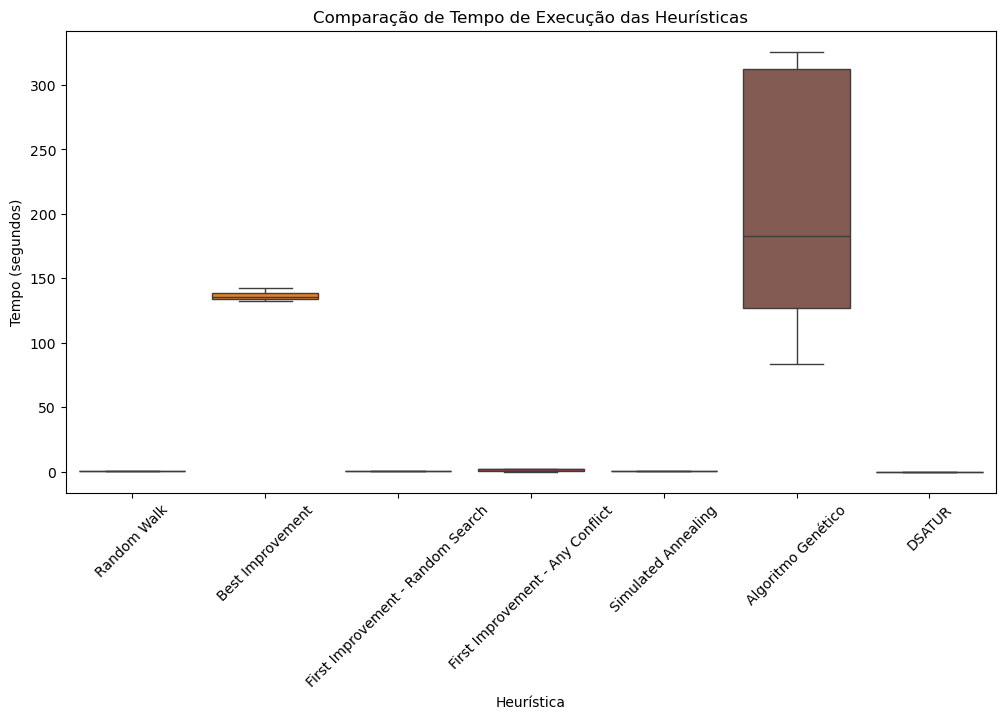

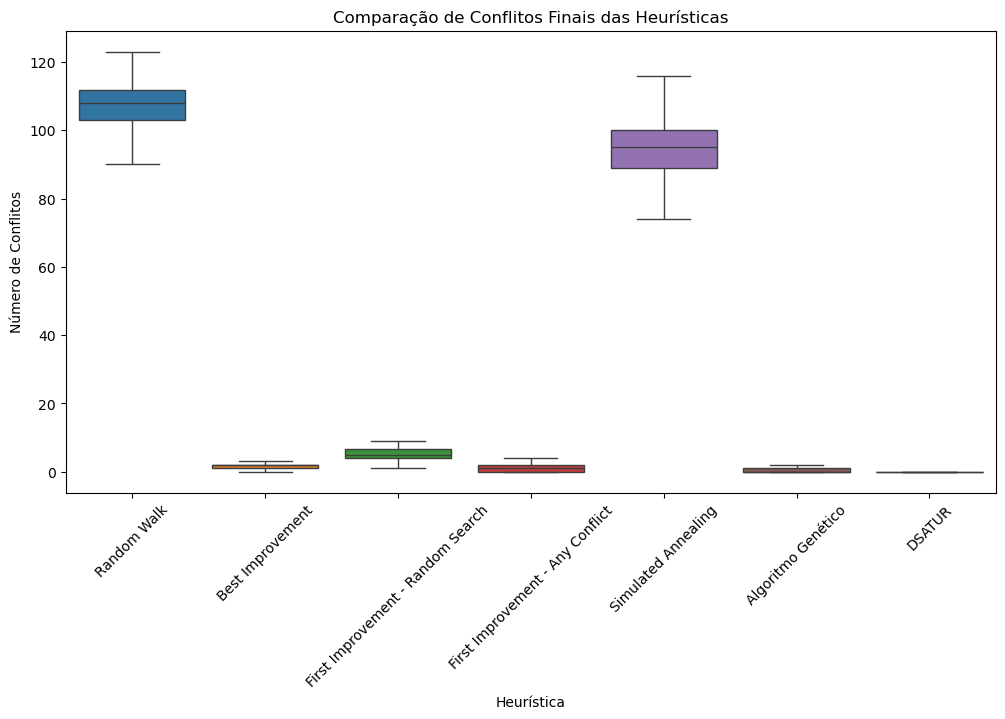

In [119]:
# Gráfico de Tempo de Execução
plt.figure(figsize=(12, 6))
sns.boxplot(data=execution_time_df, showfliers=False)  # Remove os outliers
plt.title("Comparação de Tempo de Execução das Heurísticas")
plt.ylabel("Tempo (segundos)")
plt.xlabel("Heurística")
plt.xticks(rotation=45)
plt.show()

# Gráfico de Conflitos
plt.figure(figsize=(12, 6))
sns.boxplot(data=conflitos_finais_df, showfliers=False)  # Remove os outliers
plt.title("Comparação de Conflitos Finais das Heurísticas")
plt.ylabel("Número de Conflitos")
plt.xlabel("Heurística")
plt.xticks(rotation=45)
plt.show()

Atenção: A heurística 'Random Walk' não encontrou nenhuma solução ótima em 50 execuções.
Atenção: A heurística 'First Improvement - Random Search' não encontrou nenhuma solução ótima em 50 execuções.
Atenção: A heurística 'Simulated Annealing' não encontrou nenhuma solução ótima em 50 execuções.


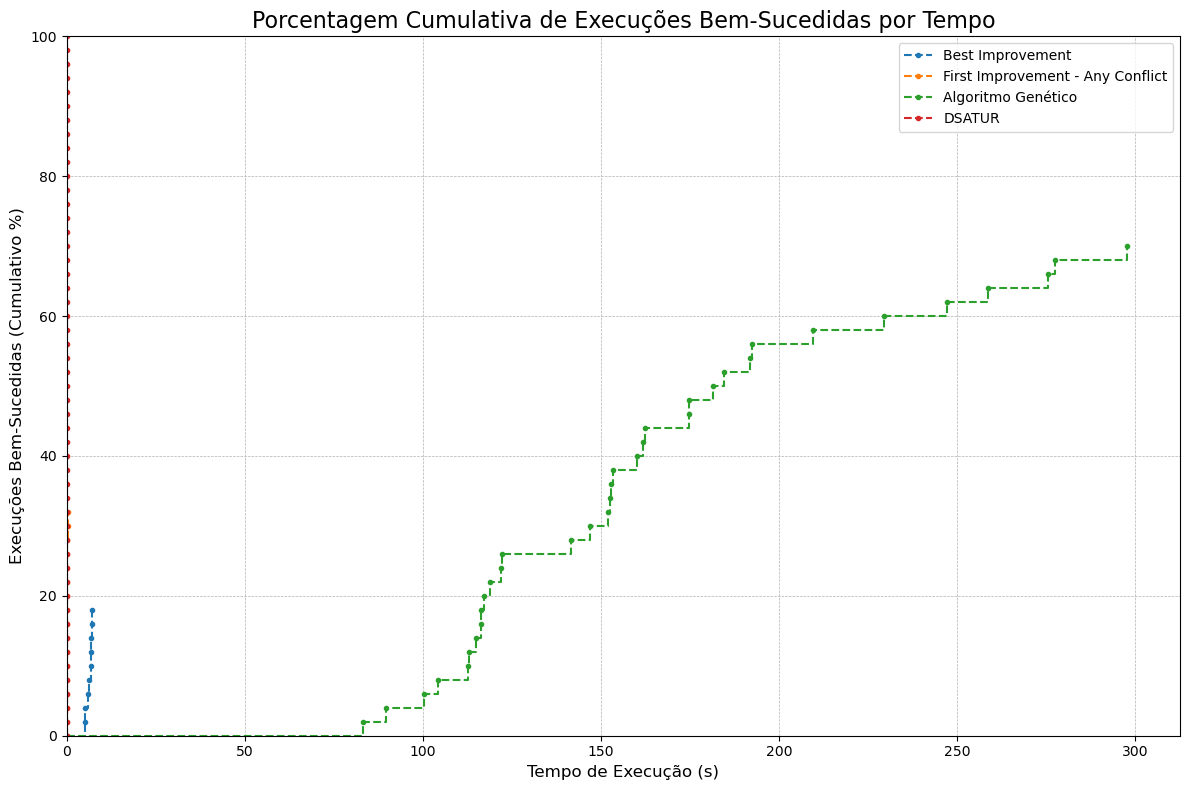

In [120]:
import numpy as np
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Nomes das heurísticas a serem plotadas
heuristics_to_plot = ['Random Walk', 'Best Improvement', 'First Improvement - Random Search', 'First Improvement - Any Conflict', 'Simulated Annealing', 'Algoritmo Genético', 'DSATUR']
n_runs = len(execution_time_df)

for method in heuristics_to_plot:
    # 1. Filtrar apenas as execuções bem-sucedidas (conflitos == 0)
    successful_runs_mask = conflitos_finais_df[method] == 0
    successful_times = execution_time_df.loc[successful_runs_mask, method]

    # Se não houver nenhuma execução bem-sucedida, pule para a próxima heurística
    if successful_times.empty:
        print(f"Atenção: A heurística '{method}' não encontrou nenhuma solução ótima em {n_runs} execuções.")
        continue

    # 2. Ordenar os tempos das execuções bem-sucedidas
    sorted_times = np.sort(successful_times)
    
    # 3. Calcular a porcentagem cumulativa
    # A porcentagem é calculada em relação ao número TOTAL de execuções (n_runs)
    cumulative_percentage = (np.arange(1, len(sorted_times) + 1) / n_runs) * 100

    # 4. Adicionar um ponto em (0, 0) para que a linha comece no eixo
    plot_times = np.insert(sorted_times, 0, 0)
    plot_percentage = np.insert(cumulative_percentage, 0, 0)

    # 5. Plotar a curva cumulativa
    ax.plot(plot_times, plot_percentage, marker='.', linestyle='--', label=method, drawstyle='steps-post')

# Configurações do gráfico
ax.set_title('Porcentagem Cumulativa de Execuções Bem-Sucedidas por Tempo', fontsize=16)
ax.set_xlabel('Tempo de Execução (s)', fontsize=12)
ax.set_ylabel('Execuções Bem-Sucedidas (Cumulativo %)', fontsize=12)
ax.set_xlim(left=0)
ax.set_ylim(0, 100)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.tight_layout()